Predicting Fold-State of Proteins 
==========

In [212]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from sklearn.cross_validation import train_test_split

from pgmpy.models import MarkovModel, BayesianModel
from pgmpy.inference import BeliefPropagation
from pgmpy.factors import Factor
from scipy import optimize
from pgmpy.estimators import MaximumLikelihoodEstimator
import pickle

import warnings
warnings.filterwarnings('ignore')

### What a protein looks like:

<img  src="85262_large.jpg"/>

In [213]:
seq = pd.read_csv('sequences.csv').drop('Unnamed: 0', axis=1).values.reshape((-1,))

### How the protein is encoded for us:

<img  src="AA_code.png" height=400 width=400/>

<img  src="protein_seq.jpg"/>

### What our actual data looks like:

In [3]:
print(seq[:100])

['V' 'L' 'S' 'P' 'A' 'D' 'K' 'T' 'N' 'V' 'K' 'A' 'A' 'W' 'G' 'K' 'V' 'G'
 'A' 'H' 'A' 'G' 'E' 'Y' 'G' 'A' 'E' 'A' 'L' 'E' 'R' 'M' 'F' 'L' 'S' 'F'
 'P' 'T' 'T' 'K' 'T' 'Y' 'F' 'P' 'H' 'F' 'D' 'L' 'S' 'H' 'G' 'S' 'A' 'Q'
 'V' 'K' 'G' 'H' 'G' 'K' 'K' 'V' 'A' 'D' 'A' 'L' 'T' 'N' 'A' 'V' 'A' 'H'
 'V' 'D' 'D' 'M' 'P' 'N' 'A' 'L' 'S' 'A' 'L' 'S' 'D' 'L' 'H' 'A' 'H' 'K'
 'L' 'R' 'V' 'D' 'P' 'V' 'N' 'F' 'K' 'L']


### How this relates to Structure

<img  src="figure1.png"/>

<img  src="proteins-and-amino-acids-32-638.jpg"/>

### Fold States:

In [102]:
labels = pd.read_csv('5_formatted_labels.csv').drop('Unnamed: 0', axis=1).values.reshape((-1,))
fold_map = dict(zip(range(6), ["H", "E", "T", "S", "B", "U"]))
folds = np.asarray([fold_map[state] for state in labels])

In [5]:
print(folds[:100])

['U' 'U' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'U' 'H'
 'H' 'H' 'H' 'H' 'H' 'U' 'T' 'T' 'S' 'U' 'U' 'S' 'T' 'T' 'U' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'T'
 'T' 'S' 'H' 'H' 'H' 'H' 'T' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'T'
 'U' 'U' 'U' 'T' 'H' 'H' 'H' 'H' 'H' 'H']


### Together

In [6]:
pd.DataFrame([folds[:100], seq[:100]], index=['Fold', 'AA'], columns=['']*100)

,,,,,,,,,,,...,,,,,,,,,,
Fold,U,U,H,H,H,H,H,H,H,H,...,U,U,U,T,H,H,H,H,H,H
AA,V,L,S,P,A,D,K,T,N,V,...,L,R,V,D,P,V,N,F,K,L


In [56]:
counts = Counter(folds)
percents = [v*1.0 / sum(counts.values()) for v in counts.values()]

perc = dict(zip(counts.keys(), percents))

### Imbalanced Classes

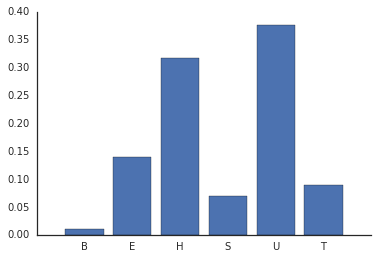

In [57]:
plt.bar(range(len(perc)), perc.values(), tick_label=perc.keys(), align='center')
sns.set_style('white')
sns.despine();

### Recall:

<img  src="cbow.png" height=400 width=400/>

### How our data is really formatted

In [7]:
skip_data = pd.read_csv('5_formatted_fixed.csv').drop('Unnamed: 0', axis=1)
skip_data.head()

,A-2,C-2,D-2,E-2,F-2,G-2,H-2,I-2,K-2,L-2,...,N2,P2,Q2,R2,S2,T2,V2,W2,Y2,-2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Take for an example:

In [65]:
print seq[:5]

['V' 'L' 'S' 'P' 'A']


In [68]:
['V-2', 'L-1', 'S0', 'P1', 'A2']

['V-2', 'L-1', 'S0', 'P1', 'A2']

In [108]:
ex0 = skip_data.ix[2]
pd.DataFrame([ex0.index, ex0.values], index=['AA', ''], columns=['']*105)

,,,,,,,,,,,...,,,,,,,,,,
AA,A-2,C-2,D-2,E-2,F-2,G-2,H-2,I-2,K-2,L-2,...,N2,P2,Q2,R2,S2,T2,V2,W2,Y2,-2
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Start with the simplest PGM and work forward:

--------

**The Plan**
* Create a Bayes Net Model
* Estimate the Thetas for the CPDs using MLE on Data
* Convert to Clique Tree
* Run Belief Propagation
* Calibrate Belief Propagation Clique Tree
* Query calibrated Belief Propagation Clique Tree

------

In [52]:
# predictors
data = pd.read_csv('5_formatted.csv').drop('Unnamed: 0', axis=1)

# labels
labels = pd.read_csv('5_formatted_labels.csv').drop('Unnamed: 0', axis=1)

# both
full_data = data.copy()
full_data['State'] = labels

# show dimensions
print(full_data.shape, data.shape, labels.shape)

(134814, 106) (134814, 105) (134814, 1)


<img  src="F1.large.jpg" height=500 width=500/>

### Get all of the $X_i$ RV Nodes and Edges

In [53]:
singletons = list(data.columns)
singletons[:5]

['A-2', 'C-2', 'D-2', 'E-2', 'F-2']

In [54]:
edges = [('State', s) for s in singletons]
edges[:5]

[('State', 'A-2'),
 ('State', 'C-2'),
 ('State', 'D-2'),
 ('State', 'E-2'),
 ('State', 'F-2')]

### Instantiate the Model

In [55]:
bn = BayesianModel()
bn.add_edges_from(edges)

In [56]:
bn.edges()[:5]

[('State', 'T0'),
 ('State', 'F1'),
 ('State', 'D0'),
 ('State', 'Y2'),
 ('State', 'P-2')]

### Split the data into train and test

In [57]:
train, test = train_test_split(np.asarray(full_data))

train_df = pd.DataFrame(train, columns=full_data.columns)
test_df = pd.DataFrame(test, columns=full_data.columns)

print(train.shape, test.shape)

(101110, 106) (33704, 106)


### Run MLE to estimate thetas for our CPDs

In [58]:
bn.cpds

[]

In [59]:
# calculate thetas in our CPDs
mle = MaximumLikelihoodEstimator(bn, train_df)

In [60]:
# example of a CPD
mle.get_parameters()[0]

State,State_0,State_1,State_2,State_3,State_4,State_5
T0_0,0.9584,0.9339,0.9503,0.9374,0.9193,0.9742
T0_1,0.0416,0.0661,0.0497,0.0626,0.0807,0.0258


In [61]:
fit_bn = mle.model

In [62]:
fit_bn.add_cpds(*mle.get_parameters())

In [63]:
fit_bn.cpds[:5]

[<TabularCPD representing P(T0:2 | State:6) at 0x118912b38>,
 <TabularCPD representing P(F1:2 | State:6) at 0x1033f0898>,
 <TabularCPD representing P(D0:2 | State:6) at 0x118912e48>,
 <TabularCPD representing P(Y2:2 | State:6) at 0x118912c88>,
 <TabularCPD representing P(P-2:2 | State:6) at 0x118912cf8>]

### What does the Clique Tree look like?

In [64]:
tree = fit_bn.to_junction_tree()

In [65]:
tree.edges()[:10]

[(('State', 'S2'), ('State', 'C2')),
 (('State', 'S2'), ('State', 'F0')),
 (('State', 'S2'), ('State', 'R-1')),
 (('State', 'S2'), ('State', 'K-1')),
 (('State', 'S2'), ('State', 'A-2')),
 (('State', 'S2'), ('State', '-0')),
 (('State', 'S2'), ('State', 'H0')),
 (('State', 'S2'), ('State', '-2')),
 (('State', 'S2'), ('State', 'W0')),
 (('State', 'S2'), ('State', 'Q-2'))]

### Now run Belief Propagation 

In [66]:
bp = BeliefPropagation(fit_bn)
bp.calibrate()

In [68]:
# label for the fifth data point
ex5_truth = int(test[5][-1])
print(ex5_truth)

3


In [69]:
ex5_evidence = dict(zip(data.columns, [int(t) for t in test[5][:-1]]))

In [70]:
# finally query
ex0_predict = bp.query(['State'], evidence=ex0_evidence)

In [71]:
ex0_predict

{'State': <Factor representing phi(State:6) at 0x11890d940>}

In [72]:
print(ex0_predict['State'])

╒═════════╤══════════════╕
│ State   │   phi(State) │
╞═════════╪══════════════╡
│ State_0 │       0.2166 │
├─────────┼──────────────┤
│ State_1 │       0.2133 │
├─────────┼──────────────┤
│ State_2 │       0.0324 │
├─────────┼──────────────┤
│ State_3 │       0.5264 │
├─────────┼──────────────┤
│ State_4 │       0.0080 │
├─────────┼──────────────┤
│ State_5 │       0.0034 │
╘═════════╧══════════════╛


In [73]:
print(np.argmax(ex0_predict['State'].values))

3


In [74]:
print(ex0_truth==np.argmax(ex0_predict['State'].values))

True


In [ ]:
# finally iterate through --- this took ~ 6 hours

test_df.to_csv('nb_test_split.csv')

preds = []

for i, t in enumerate(test):
    ev = dict(zip(full_data.columns, [int(v) for v in t[:-1]]))
    answer = bp.query(['State'], evidence=ev)
    max_v = np.argmax(answer['State'].values)
    preds.append(max_v)

pred_df = pd.DataFrame(preds, columns=['State'])
pred_df.to_csv('preds.csv')

In [ ]:
print(np.mean([1.0 if pred == int(y_i) else 0.0 for pred, y_i in zip(preds, test[:, -1])]))

**Accuracy: 0.55**

--------

# Maybe we can do better with a more sophisticated model --- HMM

<img  src="fpsyg-06-00919-g003.jpg"/>

In [83]:
from hmmlearn import hmm
from collections import defaultdict

## The Plan

* Get the possible States and Observations
* Calculate the State Prior
* Calculate the State Transition Matrix
* Calculate the State Emission Matrix
* Split Data into Train and Test
* Predict and Score

### Get our Data in the right format

In [122]:
seq_data = pd.read_csv('sequences.csv').drop('Unnamed: 0', axis=1)
seq_labels = pd.read_csv('5_formatted_labels.csv').drop('Unnamed: 0', axis=1)
seq_labels.columns = ['State']

# little bit of fixing
seq_labels = seq_labels.values.reshape(1, -1).ravel()
seq_labels = [5.0] + list(seq_labels)

(134815, 1) 134815


In [117]:
states = ['H', 'E', 'T', 'S', 'B', 'U']
features = sorted(list(set(list(seq_data.values.ravel()))))
features[:6]

['-', 'A', 'C', 'D', 'E', 'F']

In [147]:
feature_map = {k: i for i, k in enumerate(features)}
sequence = [feature_map[aa] for aa in seq_data.values.ravel()]
sequence = np.asarray(sequence).reshape(-1, 1)
sequence[:5]

array([[18],
       [10],
       [16],
       [13],
       [ 1]])

### Get the starting probabilities for States

In [178]:
# getting the starting probability 
start_prob = Counter(seq_labels)
total = sum(start_prob.values())

start_prob = {k: v*1.0/total for k, v in start_prob.items()}

start_prob = start_prob.values()
start_prob = np.asarray([v for v in start_prob]).reshape(-1, )

pd.DataFrame([states, list(start_prob)], columns=['']*6, index=['State', 'P(State)'])

,,,,,,
State,H,E,T,S,B,U
P(State),0.316589,0.138976,0.089671,0.0687683,0.010125,0.375871


### Calculate the Transition Matrix for Hidden States

In [180]:
# calculate transitions
trans = defaultdict(int)

for i in range(len(seq_labels)-1):
    
    if seq_labels[i] not in trans:
        trans[seq_labels[i]] = defaultdict(int)
    
    trans[seq_labels[i]][seq_labels[i+1]] += 1
    
t_mat = pd.DataFrame(trans)

trans_mat = np.asarray([l*1.0/sum(l) for l in t_mat.values])

pd.DataFrame(trans_mat, columns=states, index=states)

,H,E,T,S,B,U
H,0.895246,0.004616,0.015346,0.017994,0.002343,0.064455
E,0.006618,0.799690,0.035013,0.044994,0.002615,0.111070
T,0.197866,0.052610,0.510464,0.052196,0.015799,0.171065
S,0.080574,0.061051,0.162118,0.351634,0.016935,0.327688
B,0.054212,0.047619,0.160440,0.158974,0.030769,0.547985
U,0.022379,0.045173,0.056935,0.070098,0.016301,0.789114


### Calculate the Emission Matrix

In [166]:
amino_acids = list(seq_data.values.reshape(1, -1).ravel())

emis = defaultdict(int)

for l, aa in zip(seq_labels, amino_acids):
    
    if l not in emis:
        emis[l] = defaultdict(int)
    
    emis[l][aa] += 1

emis_df = pd.DataFrame(emis)
# we know they're really just zeros
emis_df.fillna(value=0.0, inplace=True)

emiss_mat = emis_df.values.T

emiss_mat = np.asarray([l/sum(l) for l in emiss_mat])

In [167]:
pd.DataFrame(emiss_mat, index=states, columns=features)

,-,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
H,0.000023,0.115953,0.009184,0.050397,0.087861,0.042103,0.038026,0.020782,0.060144,0.060120,...,0.027460,0.033036,0.025281,0.048171,0.061878,0.046484,0.041845,0.063963,0.015956,0.030857
E,0.000000,0.058550,0.016973,0.033091,0.046114,0.059991,0.051132,0.023751,0.104772,0.049424,...,0.024658,0.023057,0.020869,0.025726,0.043553,0.044780,0.064902,0.137863,0.014411,0.049637
T,0.000000,0.061957,0.008686,0.080073,0.068078,0.027049,0.165440,0.030854,0.021176,0.061874,...,0.016048,0.071470,0.069981,0.035983,0.045744,0.061957,0.050211,0.026636,0.011167,0.029283
S,0.000000,0.061806,0.008845,0.076151,0.062237,0.036350,0.140114,0.030094,0.036134,0.058462,...,0.018660,0.059864,0.051343,0.032575,0.052853,0.066120,0.064394,0.040772,0.010894,0.028152
B,0.000000,0.036630,0.013187,0.045421,0.036630,0.073993,0.071795,0.029304,0.086447,0.037363,...,0.025641,0.029304,0.053480,0.040293,0.057875,0.054945,0.073260,0.073993,0.015385,0.054945
U,0.593906,0.028220,0.004736,0.034989,0.019517,0.014899,0.031220,0.011209,0.016794,0.020011,...,0.008446,0.020642,0.038995,0.013222,0.017287,0.029167,0.025753,0.023839,0.005269,0.013242


## Finally, model with the HMM 

In [204]:
model = hmm.MultinomialHMM(n_components=6, init_params='')

In [205]:
model.startprob_prior = start_prob
model.transmat_prior = trans_mat
model.emissionprob_ = emiss_mat
model.n_features = len(features)

In [206]:
model.fit(sequence)

MultinomialHMM(algorithm='viterbi', init_params='', n_components=6, n_iter=10,
        params='ste',
        random_state=<mtrand.RandomState object at 0x1090b3470>,
        startprob_prior=array([ 0.31659,  0.13898,  0.08967,  0.06877,  0.01012,  0.37587]),
        tol=0.01,
        transmat_prior=array([[ 0.89525,  0.00462,  0.01535,  0.01799,  0.00234,  0.06445],
       [ 0.00662,  0.79969,  0.03501,  0.04499,  0.00262,  0.11107],
       [ 0.19787,  0.05261,  0.51046,  0.0522 ,  0.0158 ,  0.17106],
       [ 0.08057,  0.06105,  0.16212,  0.35163,  0.01693,  0.32769],
       [ 0.05421,  0.04762,  0.16044,  0.15897,  0.03077,  0.54799],
       [ 0.02238,  0.04517,  0.05693,  0.0701 ,  0.0163 ,  0.78911]]),
        verbose=False)

In [207]:
preds = model.predict(sequence)

In [190]:
print(np.mean([1.0 if y_p==y_i else 0.0 for y_p, y_i in zip(preds, labels)]))

0.538252703725


# Why this likely isn't working

### LONG-RANGE DEPENDENCIES

<img  src="T7_Protein.jpg"/>

Sound familiar?

<img  src="slide_8.jpg" height=600 width=600/>

### Amino Acids NOT independent of one another

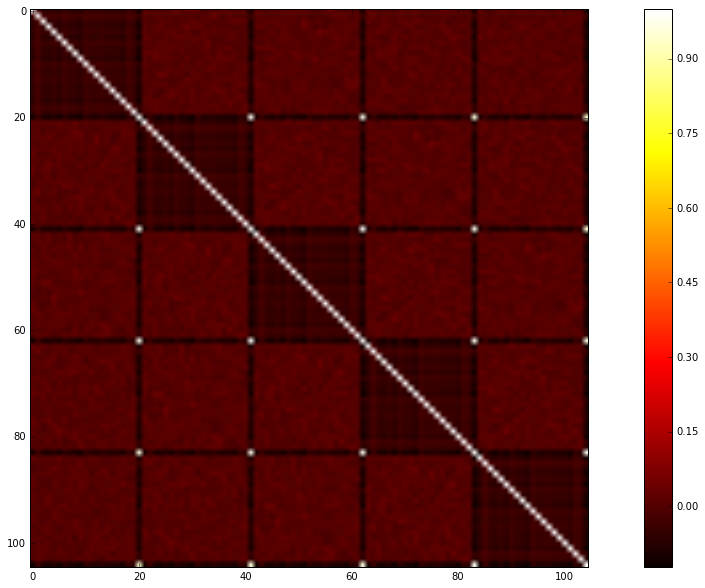

In [21]:
small_ex = skip_data.as_matrix()[:10000, :]
r = np.corrcoef(small_ex, rowvar=0)

plt.figure(figsize=(20,10))
plt.imshow(r, cmap='hot')
plt.colormaps
plt.colorbar();

## Future Work

In [22]:
link = 'https://cran.r-project.org/web/packages/CRF/CRF.pdf'

In [26]:
from IPython.display import IFrame

* Expand HMM features to positional amino acids (ex. A-2 vs. A)
* Learn enough R to do ... 

In [31]:
IFrame(link, width=400, height=500)